In [1]:
import argparse
import glob
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
from UNet.unet import UNet
from unet import train_model, test

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
# os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

dataset_dir = "smalldataset/dataset"

In [4]:
def get_a_random_image(dir=dataset_dir + "/train"):
    all_videos = os.listdir(dir)
    picked_video = random.choice(all_videos)
    all_images = os.listdir(os.path.join(dir, picked_video))
    picked_image = random.choice(all_images)
    picked_image_idx = int(picked_image[len("image_"):-len(".png")])

    img = Image.open(os.path.join(dir, picked_video, picked_image))
    data = np.asarray(img, dtype="int32")

    mask = np.load(os.path.join(dir, picked_video, "mask.npy"))
    return data, mask[picked_image_idx]

In [5]:
"""## Plotting images to visualize more masked frames"""
def visualize_labels(dir=dataset_dir + "/train", num_frames=5):
    all_videos = os.listdir(dir)
    picked_video = random.choice(all_videos)
    video_path = os.path.join(dir, picked_video)
    all_images = sorted([img for img in os.listdir(video_path) if img.startswith('image_')])
    picked_images = random.sample(all_images, num_frames)

    mask = np.load(os.path.join(video_path, "mask.npy"))

    plt.figure(figsize=(15, 3 * num_frames))

    for i, img_name in enumerate(picked_images):
        img_path = os.path.join(video_path, img_name)
        img = Image.open(img_path)
        print("img size: ", img.size, '\n')
        data = np.asarray(img, dtype="int32")
        frame_idx = int(img_name[len("image_"):-len(".png")])

        plt.subplot(num_frames, 2, 2*i + 1)
        plt.imshow(data)
        plt.title(f"Frame {frame_idx}")
        plt.axis('off')

        plt.subplot(num_frames, 2, 2*i + 2)
        plt.imshow(mask[frame_idx])
        plt.title(f"Mask for Frame {frame_idx}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Call the function to visualize labels

In [6]:
def visualize(): 
    print(f"The training set has {len(os.listdir(dataset_dir + '/train'))} videos, and each video has {len(glob.glob(dataset_dir + '/train/video_00000/*.png'))} frames and {len(glob.glob(dataset_dir + '/train/video_00000/*.npy'))} mask file for all frames")
    print(f"The validation set has {len(os.listdir(dataset_dir + '/val'))} videos, and each video has {len(glob.glob(dataset_dir + '/val/video_01000/*.png'))} frames and {len(glob.glob(dataset_dir + '/val/video_01000/*.npy'))} mask file for all frames")
    print(f"The unlabeled set has {len(os.listdir(dataset_dir + '/unlabeled'))} videos, and each video has {len(glob.glob(dataset_dir + '/unlabeled/video_02000/*.png'))} frames and {len(glob.glob(dataset_dir + '/unlabeled/video_02000/*.npy'))} mask file for all frames")

    mask = np.load(dataset_dir + '/train/video_00000/mask.npy')
    print(f"The mask file has the shape {mask.shape}.")
    img = Image.open(dataset_dir + '/train/video_00000/image_0.png')
    data = np.asarray(img, dtype="int32")
    print(f"Each image has the shape {data.shape}")

    print("Let's visualize them:")

    data, mask = get_a_random_image()
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.imshow(data)
    plt.axis('off')

    # Plot the second image
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.imshow(mask)
    plt.axis('off')

    # visualize_labels(f"smalldataset/dataset/train", num_frames=10)

In [7]:
def get_args():
    parser = argparse.ArgumentParser(description='Train the UNet on images and target masks')
    parser.add_argument('--epochs', '-e', metavar='E', type=int, default=5, help='Number of epochs')
    parser.add_argument('--batch-size', '-b', dest='batch_size', metavar='B', type=int, default=16, help='Batch size')
    parser.add_argument('--learning-rate', '-l', metavar='LR', type=float, default=1e-5,
                        help='Learning rate', dest='lr')
    parser.add_argument('--load', '-f', type=str, default=False, help='Load model from a .pth file')
    parser.add_argument('--amp', action='store_true', default=False, help='Use mixed precision')
    args = parser.parse_args()
    return args

mps
The training set has 11 videos, and each video has 22 frames and 1 mask file for all frames
The validation set has 12 videos, and each video has 22 frames and 1 mask file for all frames
The unlabeled set has 11 videos, and each video has 22 frames and 0 mask file for all frames
The mask file has the shape (22, 160, 240).
Each image has the shape (160, 240, 3)
Let's visualize them:


Epoch 1/1:   0%|                                                                   | 0/220 [00:00<?, ?img/s]/opt/anaconda3/envs/dl-project/lib/python3.12/site-packages/torch/optim/rmsprop.py:347: UserWarning: The operator 'aten::_foreach_add.List' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403226120/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  grouped_grads = torch._foreach_add(grouped_grads, grouped_params, alpha=weight_decay)
 91%|█████████████████████████▍  | 40/44 [00:00<00:00, 63.77it/s, dice score=tensor(6.2394, device='mps:0')]
45it [00:00, 63.77it/s, dice score=tensor(7.0519, device='mps:0')]                                          
50it [00:00, 64.49it/s, dice score=tensor(7.0519, device='mps:0')]
50it [00:00, 64.49it/s, dice score=tensor(7.8560, device='mps:0')]
55it [00:00, 64.49it/s, dice score=tensor(8.6185, devi

Epoch: 1, dice-score: 0.7847877740859985


/Users/satyachillale/Library/CloudStorage/OneDrive-nyu.edu/NYU/Courses/Deep Learning/project/Paradigm/unet.py:141: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


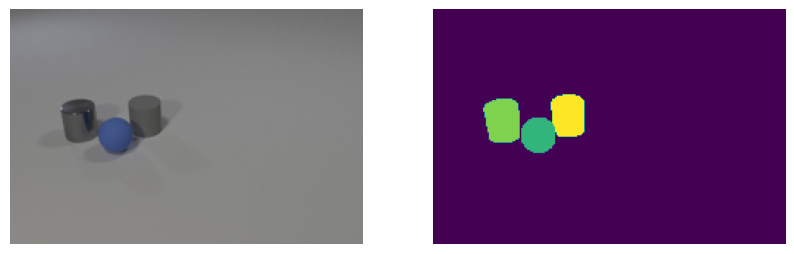

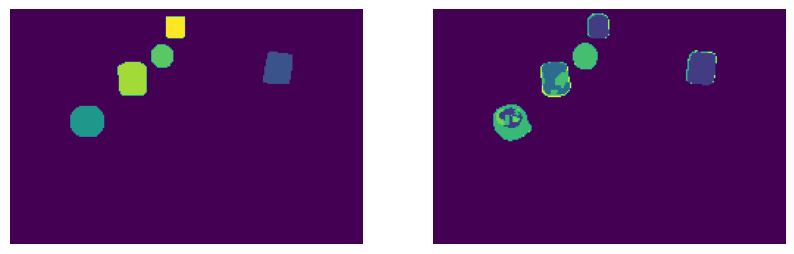

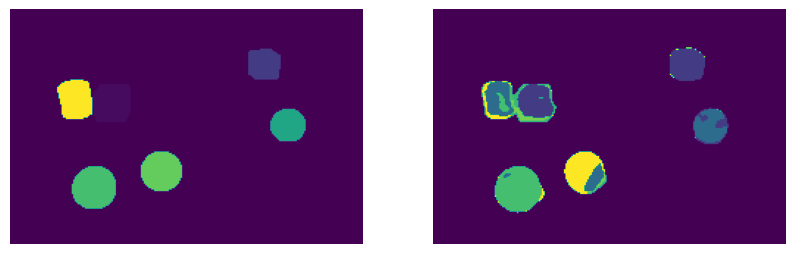

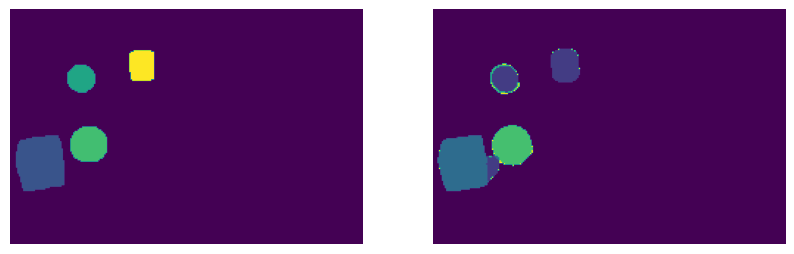

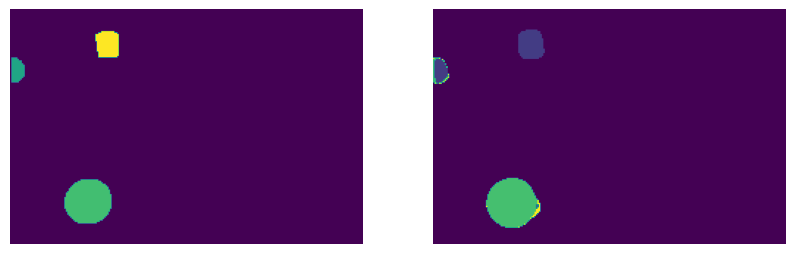

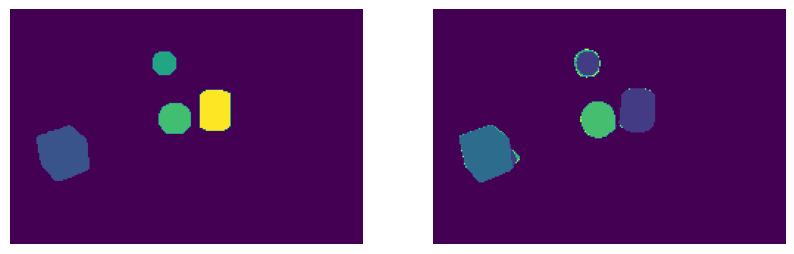

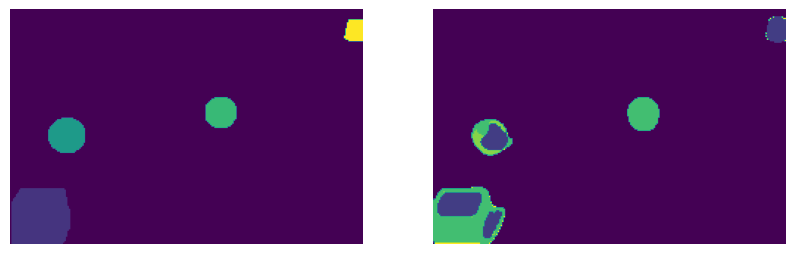

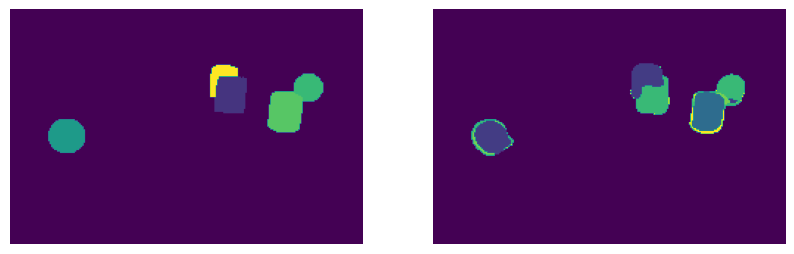

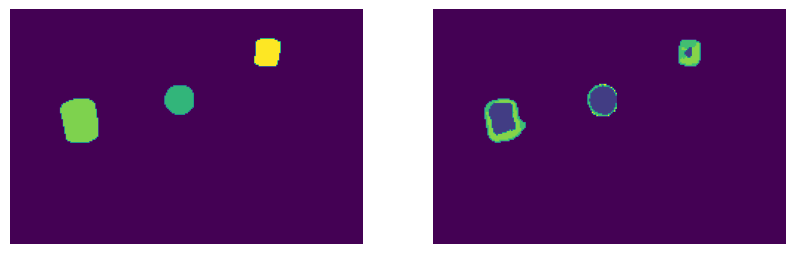

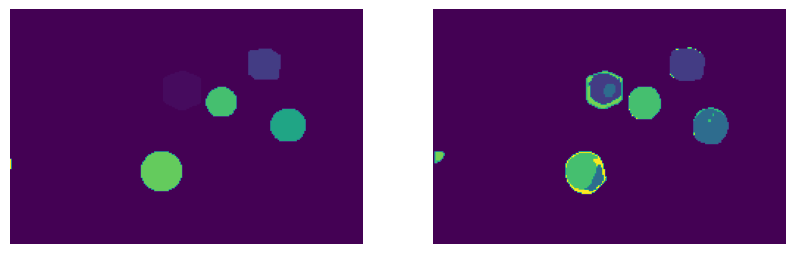

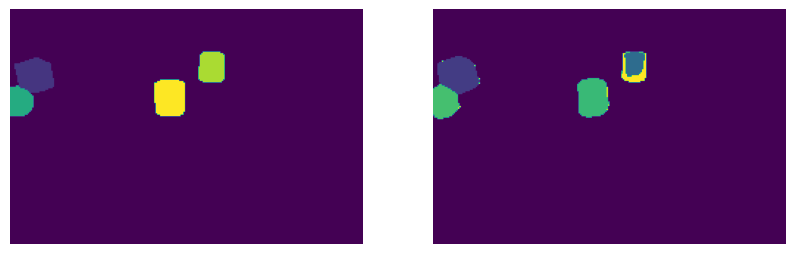

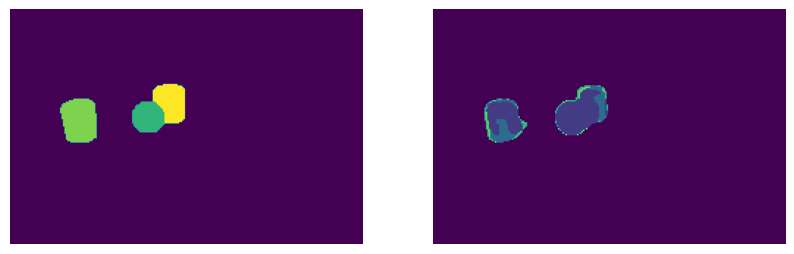

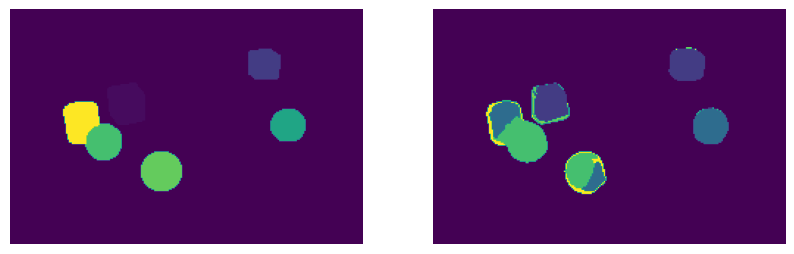

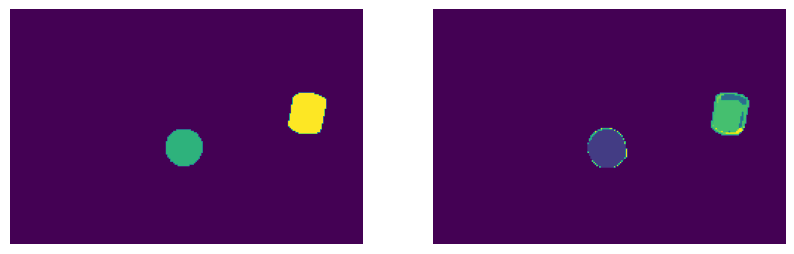

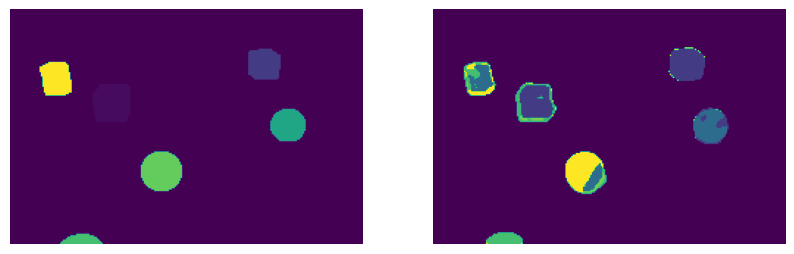

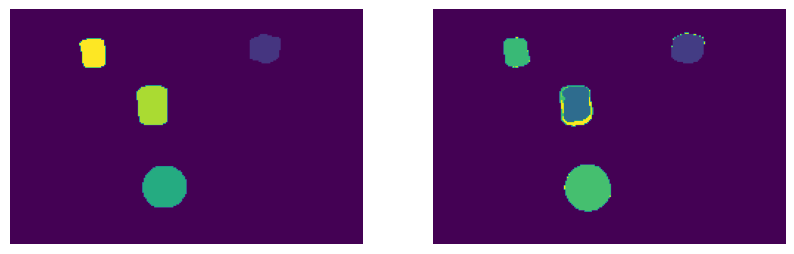

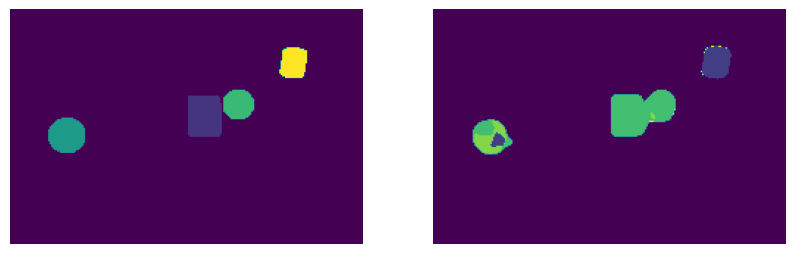

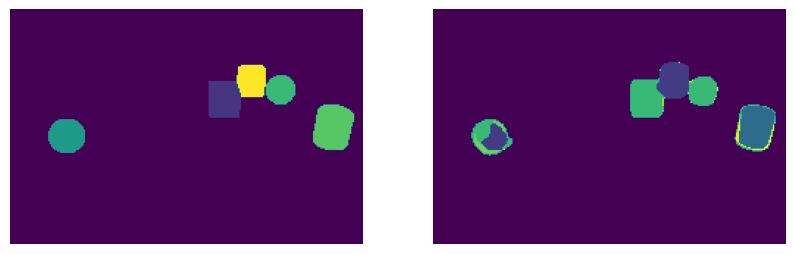

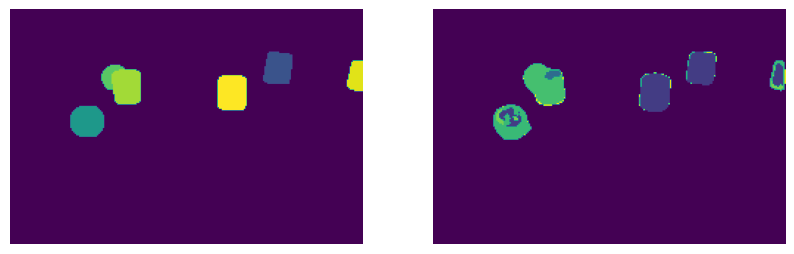

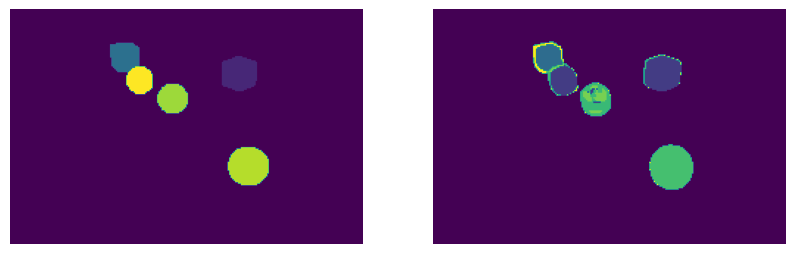

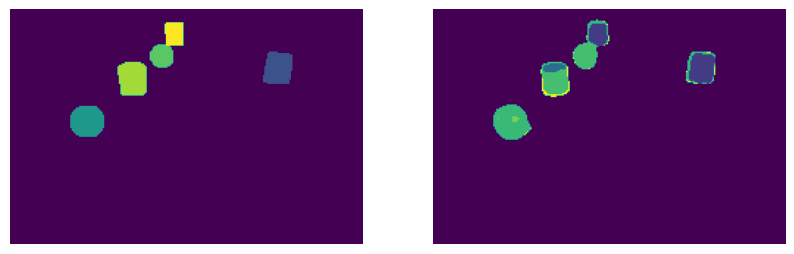

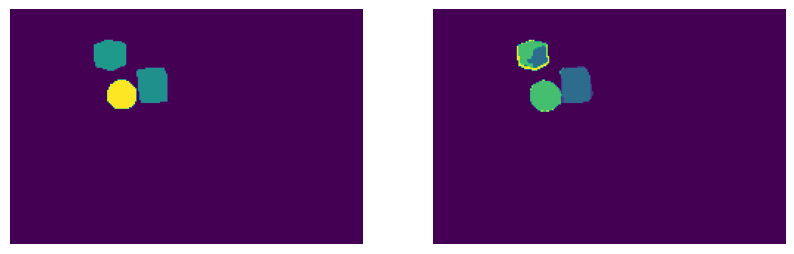

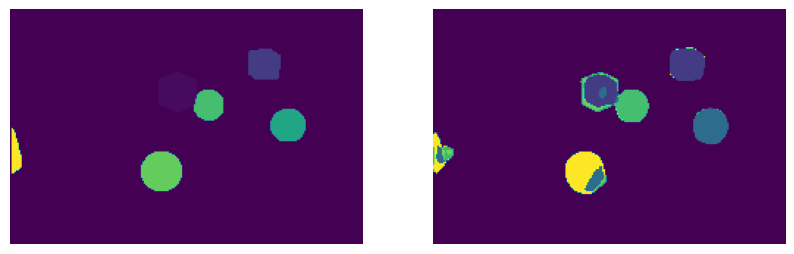

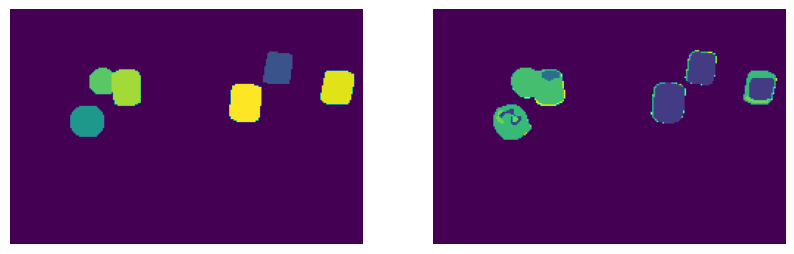

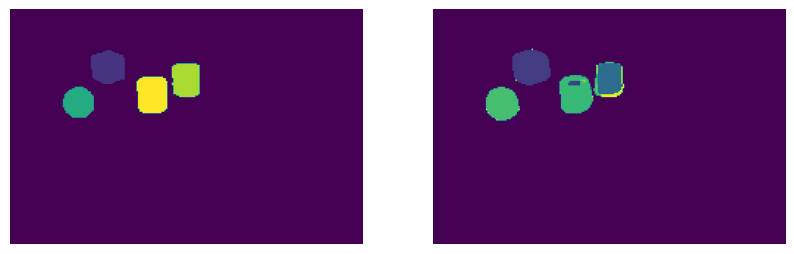

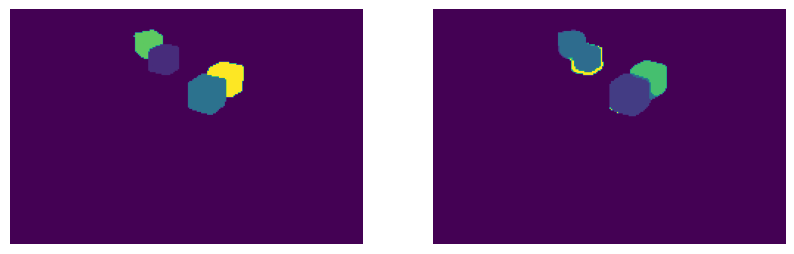

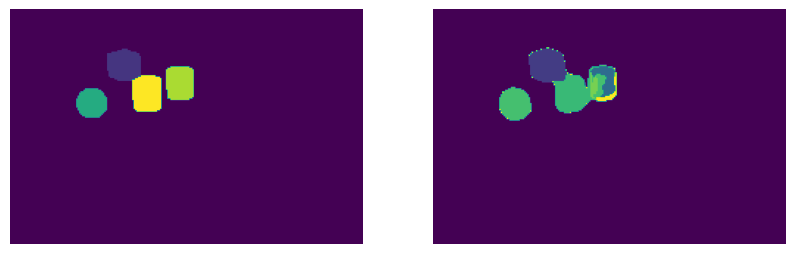

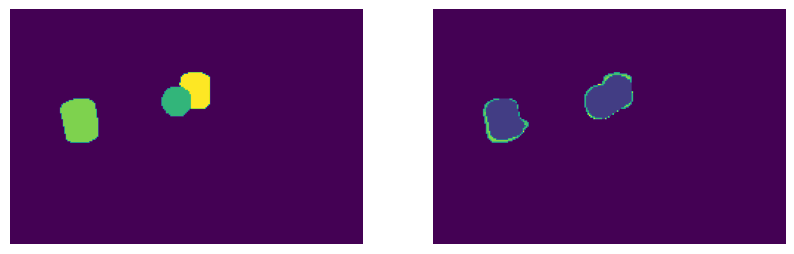

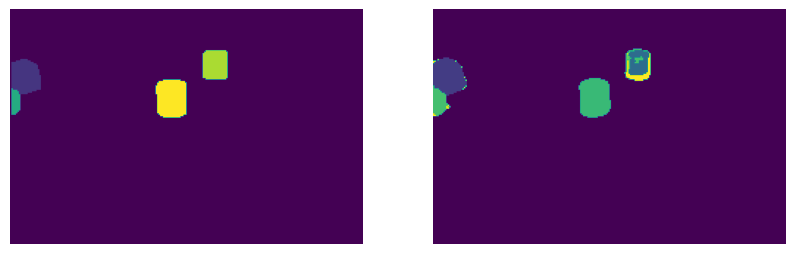

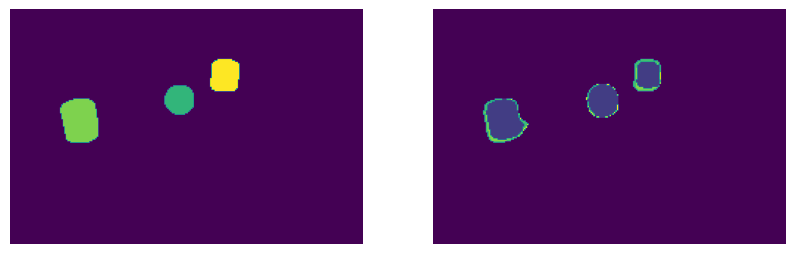

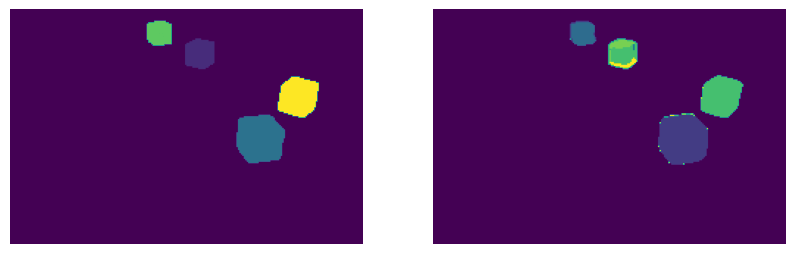

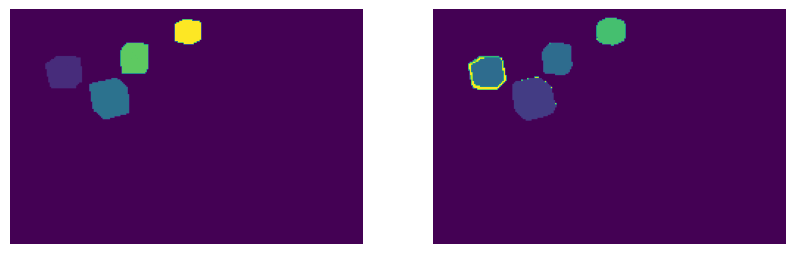

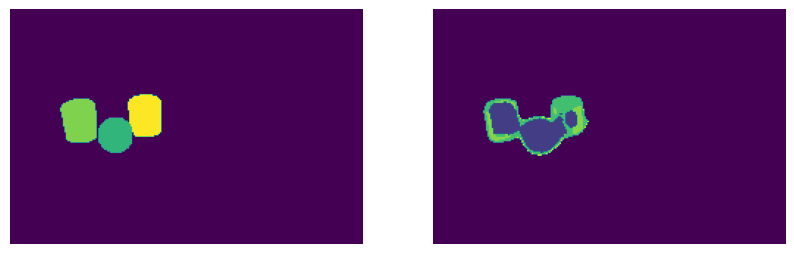

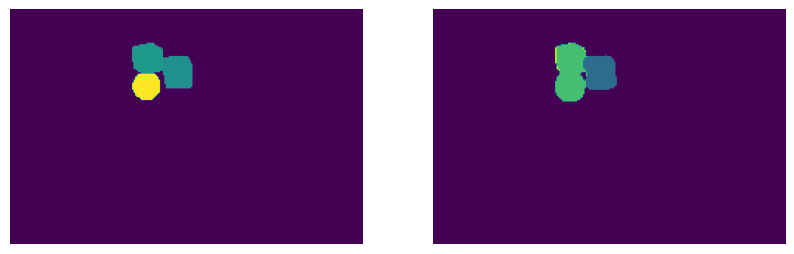

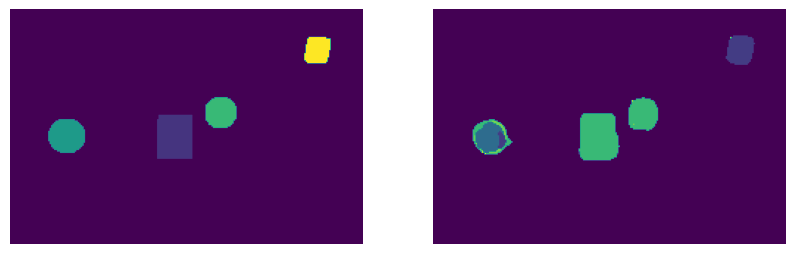

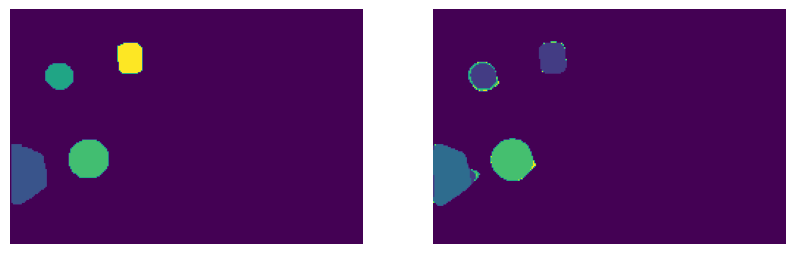

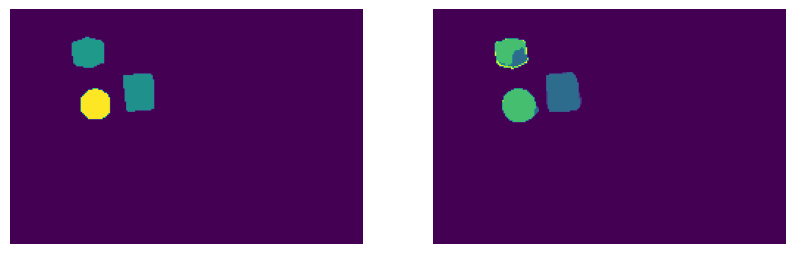

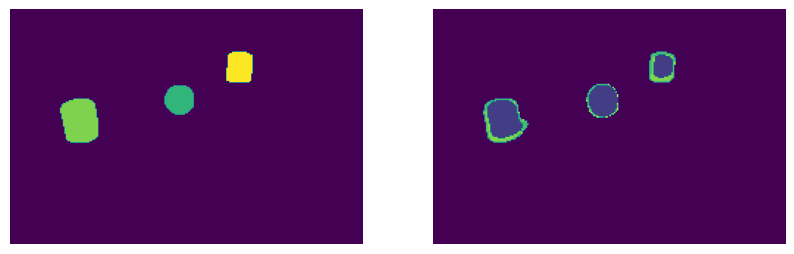

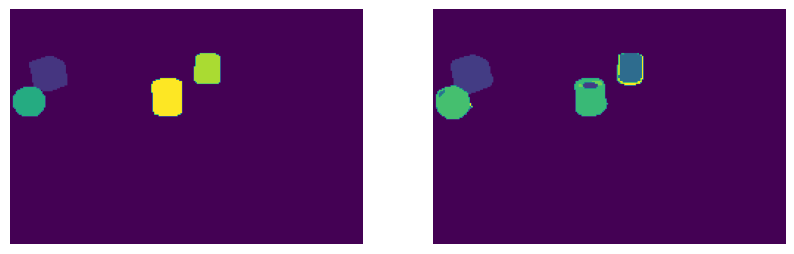

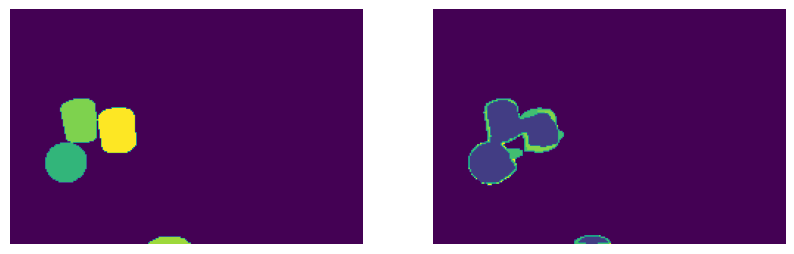

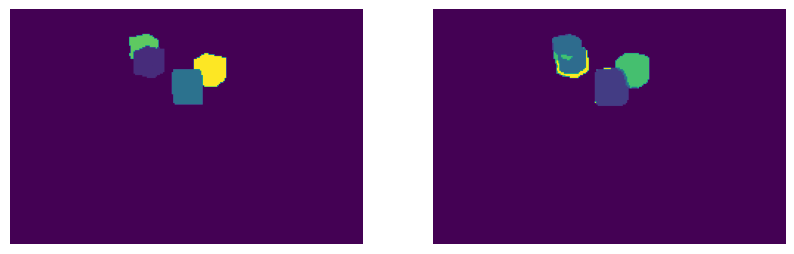

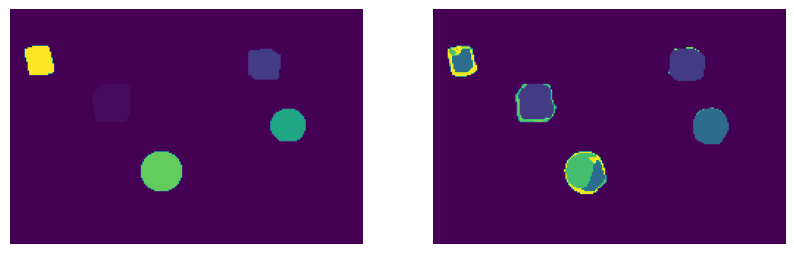

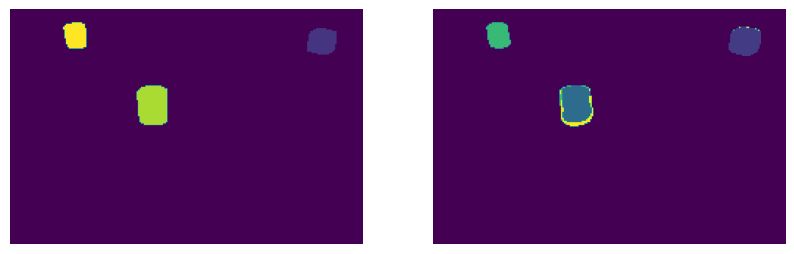

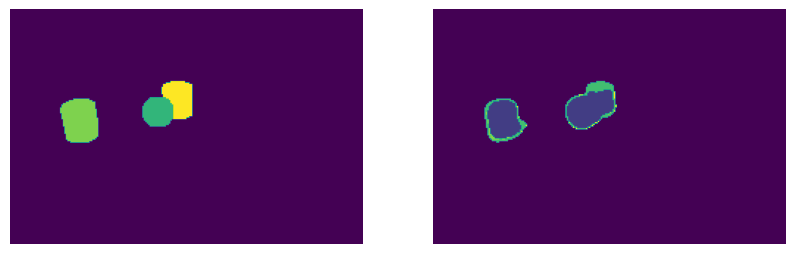

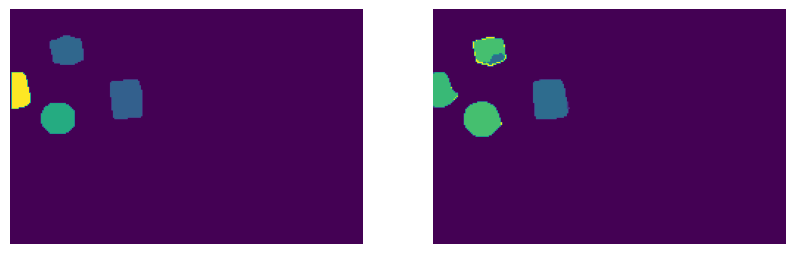

In [8]:
if __name__ == '__main__':
    args = get_args()
    print(device)
    visualize()
    model = UNet(n_channels=3, n_classes=49, bilinear=True)
    model = model.to(memory_format=torch.channels_last)
    model.to(device=device)
    train_model(
        model=model,
        dataset_dir=dataset_dir,
        device=device,
        epochs=args.epochs,
        batch_size=args.batch_size,
        learning_rate=args.lr,
        amp=args.amp
    )
    test(model, dataset_dir, args.batch_size, device)